# iris tomography codes and other stuff

In [1]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

## import data from database

In [2]:
orbit = 20900
num_of_orbits = 1
ch = 3

db = sql.connect('../OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')    
print('num of images: {}'.format(len(all_image)))

l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), 
                      dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), 
                       attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), 
                       attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), 
                       attrs={'units':'meter'})
import pandas as pd
from geometry_functions import lla2ecef
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

#====drop all dates which have nan in l1
l1 = l1.dropna('date')
sc_look = sc_look.sel(date=l1.dropna('date').date)
sc_pos = sc_pos.sel(date=l1.dropna('date').date)
tan_lat = tan_lat.sel(date=l1.dropna('date').date)
tan_lon = tan_lon.sel(date=l1.dropna('date').date)
tan_alt = tan_alt.sel(date=l1.dropna('date').date)
date = l1.dropna('date').date.data
print('num of images after removing nan: {}'.format(len(date)))

num of images: 5792
num of images after removing nan: 4784


# choose some images and pixels 

In [3]:
#====choose mesurements
im_lst = np.arange(1950,2000, 1) # dayglow example
#im_lst = np.arange(2000,2050, 5) # datglow doesnt work (scanning)
#im_lst = np.arange(500,550, 5) #nightglow example
pix_lst = np.arange(22,128)

# plot limb radiance

/Users/anqili/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


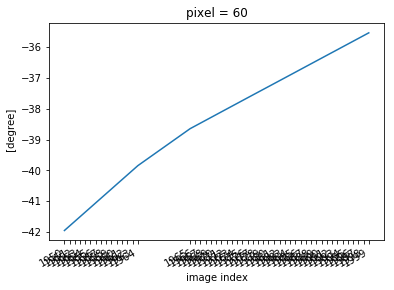

/Users/anqili/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


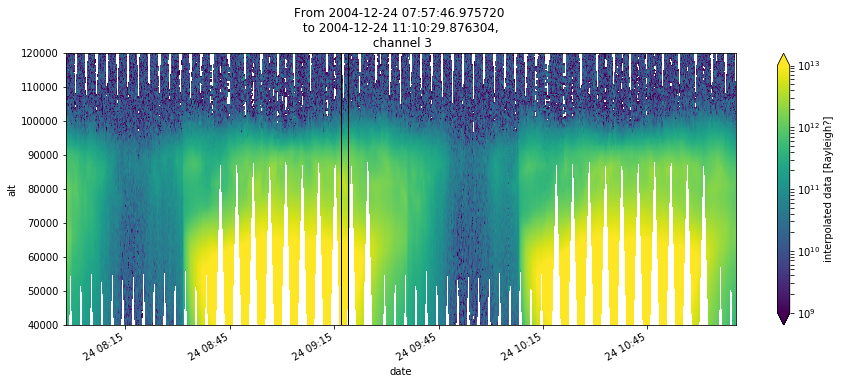

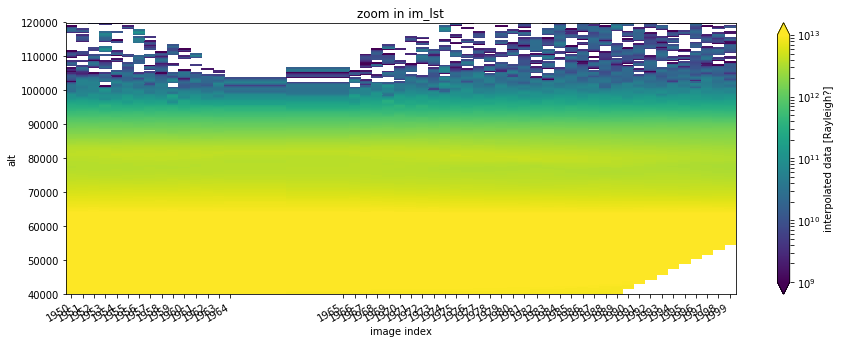

/Users/anqili/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


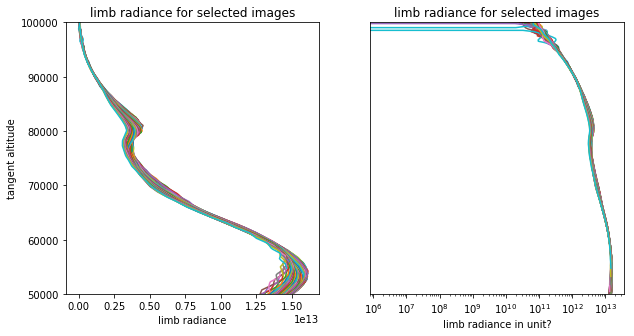

In [4]:
tan_lat.isel(date=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)
ax.set(xlabel='image index')
plt.show()


alts_interp = np.arange(40e3, 120e3, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, 
                           coords=(date, alts_interp), 
                           dims=('date', 'alt'))
data_interp.attrs['units'] = 'Rayleigh?'
data_interp.attrs['long_name'] = 'interpolated data'

#==== plot something
plt.figure()
data_interp.plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), ch))
plt.axvline(x=date[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=date[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(date=im_lst).plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst',
      xlabel='image index')
ax.set_xticks(date[im_lst])
ax.set_xticklabels(im_lst)
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.subplot(122)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(xlabel='limb radiance in unit?',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])
ax.set_xscale('log')
plt.yticks([])
plt.show()

### change coordinate to across- along-track 

In [5]:
#====define the new base vectors
n_crosstrack = np.cross(sc_look.isel(date=im_lst[0], pixel=60),
                        sc_pos.isel(date=im_lst[0]))
n_vel = np.cross(sc_pos.isel(date=im_lst[0]), n_crosstrack)
n_zenith = sc_pos.isel(date=im_lst[0])

#====tangent points in alpha, beta, rho coordinate
import pandas as pd
from geometry_functions import lla2ecef, cart2sphe, change_of_basis
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

tan_alpha = []
tan_beta = []
tan_rho = []
for i in im_lst:
    p_old = tan_ecef.isel(date=i, pixel=pix_lst)
    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z'))
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=[date[im_lst], pixel[pix_lst]],
                         dims=['date', 'pixel'])
tan_beta = xr.DataArray(tan_beta, 
                        coords=[date[im_lst], pixel[pix_lst]],
                        dims=['date', 'pixel'])
tan_rho = xr.DataArray(tan_rho, 
                       coords=[date[im_lst], pixel[pix_lst]],
                       dims=['date', 'pixel'])

Re = 6371 + 100 #Earth radius in km

# 1D inversion

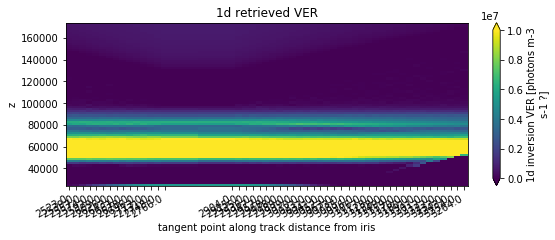

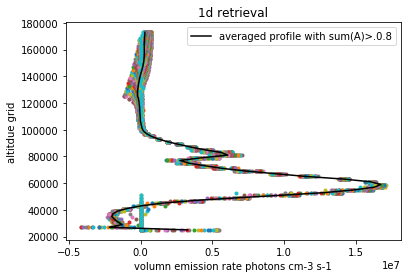

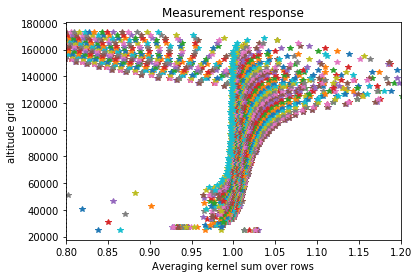

In [6]:
from oem_functions import linear_oem
from geometry_functions import pathl1d_iris

z = np.arange(25e3, 175e3, 2e3) # m
z_top = z[-1] + 2e3
result_1d = np.zeros((len(im_lst), len(z)))
xa = np.ones(len(z)) *0 # temp
Sa = np.diag(np.ones(len(z))) *1e-9 #temp
Se = np.diag(np.ones(len(pixel))) * 30# 1e10 #30 #temporary
Ave = []
for i in range(len(im_lst)):
    h = tan_alt.isel(date=im_lst[i]).data
    K = pathl1d_iris(h, z, z_top)    
    y = l1.isel(date=im_lst[i]).data    
#    Se = np.diag(error.data[i,:]**2)
    x, A, Ss, Sm = linear_oem(K, Se, Sa, y, xa)
    result_1d[i,:] = x
    Ave.append(A.sum(axis=1)) #sum over rows 

result_1d = xr.DataArray(result_1d, 
                         coords=(date[im_lst], z), 
                         dims=('date', 'z'))
result_1d.attrs['units'] = 'photons m-3 s-1 ?'
result_1d.attrs['long_name'] = '1d inversion VER'
Ave = np.array(Ave)
mr_threshold = 0.8
result_1d_mean = result_1d.where(Ave>mr_threshold).mean(dim='date')

# plot VER results
result_1d.plot(x='date', y='z',
#         norm=LogNorm(), 
         vmin=0, vmax=1e7, 
         size=3, aspect=3)
ax = plt.gca()
ax.set(title='1d retrieved VER',
      xlabel='tangent point along track distance from iris')
ax.set_xticks(date[im_lst])
ax.set_xticklabels(np.round(tan_beta.sel(pixel=60).data*Re))
plt.show()

plt.figure()
ax = plt.gca()
ax.plot(result_1d.T, z, '.')
result_1d_mean.plot(y='z', color='k',ls='-',
                    label='averaged profile with sum(A)>.{}'.format(mr_threshold))
ax.set_xscale('linear')
ax.set(#xlim=[1e4, 1e8],
       xlabel='volumn emission rate photons cm-3 s-1', 
       ylabel='altitdue grid',
       title='1d retrieval')
ax.legend()
plt.show()

# plot averaging kernel
plt.plot(Ave.T, z, '*')
plt.xlabel('Averaging kernel sum over rows')
plt.ylabel('altitude grid')
plt.title('Measurement response')
plt.xlim([mr_threshold, 1.2])
plt.axvline(x=mr_threshold, ls=':', color='k')
#plt.text(mr_threshold, z[-1], 'threshold')
plt.show()



# === Tomography === 

### define atmospheric grid

In [8]:
#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 2) #radian
edges_beta = np.linspace(tan_beta.min()-0.1,
                         tan_beta.max()+0.15, 15) #radian
edges_rho = np.append(z,z_top) # meter
edges = edges_alpha, edges_beta, edges_rho

#====grid points for plotting
grid_alpha = np.append(edges_alpha - np.gradient(edges_alpha)/2, 
                       edges_alpha[-1]+np.gradient(edges_alpha)[-1]/2)
grid_beta = np.append(edges_beta - np.gradient(edges_beta)/2, 
                       edges_beta[-1]+np.gradient(edges_beta)[-1]/2)
grid_rho = np.append(edges_rho - np.gradient(edges_rho)/2, 
                       edges_rho[-1]+np.gradient(edges_rho)[-1]/2)

### build tomo jacobian for the chosen images and pixels

In [9]:
#====num of columns & rows of jacobian
col_len = len(grid_alpha) * len(grid_beta) * len(grid_rho)
row_len = len(im_lst) * len(pix_lst)

#====measure pathlength in each bin
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for image in im_lst:
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look[image].T)
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos[image])
    lx, ly, lz = los_points_fix_dl(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    for pix in pix_lst:#range(pix_start, pix_end):   
        los = los_alpha.sel(pixel=pix), los_beta.sel(pixel=pix), los_rho.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))


### Tomo (MAP/OEM) inversion

In [10]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
y = l1.isel(date=im_lst, pixel=pix_lst).data.ravel()
y[y<0] = 0 #temp
#xa = np.ones(col_len) # temp
xa = interp1d(z, result_1d_mean.data, fill_value='extrapolate')(grid_rho)
xa = np.tile(xa, (len(grid_alpha),len(grid_beta),1)).ravel()
Sa = sp.diags([1], shape=(col_len, col_len)) *1 #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id)) * 1e10 #temp
x_hat, G = linear_oem_sp(K_coo, Se, Sa, y, xa)

shape_tomo = (len(grid_alpha), len(grid_beta), len(grid_rho))
result_tomo = x_hat.reshape(shape_tomo)
result_tomo = xr.DataArray(result_tomo, 
                           coords=(grid_alpha, grid_beta, grid_rho), 
                           dims=('alpha', 'beta', 'rho')) #temp

/Users/anqili/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/anqili/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


#### Plot some (tomo) restuls (need to find a better way to plot a 3d volume)


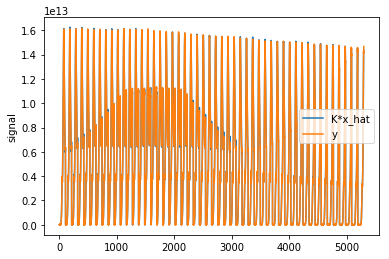

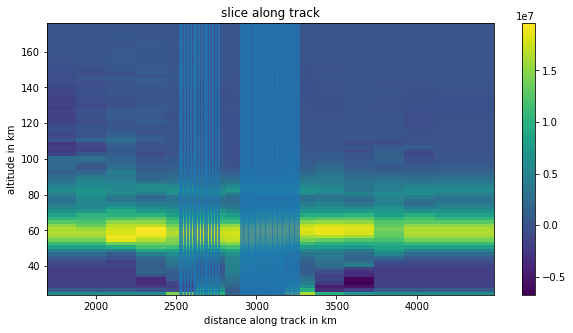

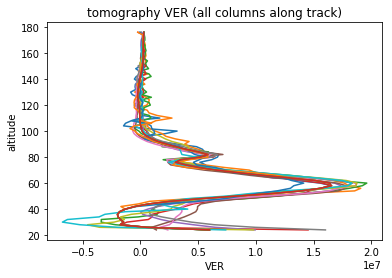

In [11]:
%matplotlib inline
#====check residual
plt.figure()
plt.plot(K_coo.dot(x_hat), label='K*x_hat')
plt.plot(y, label='y')
plt.ylabel('signal')
plt.legend()
plt.show()

#====contour plot 
plt.figure(figsize=(10,5))
#plt.subplot(121)
plt.pcolor(grid_beta*Re, grid_rho*1e-3, result_tomo.isel(alpha=1).T)
plt.xlabel('distance along track in km')
plt.ylabel('altitude in km')
plt.title('slice along track')
plt.colorbar()
for i in range(0,len(im_lst),1):
    plt.axvline(x=tan_beta.sel(pixel=60)[i].data*Re)
#ax = plt.gca()
#ax2 = ax.twiny()
#ax2.set_xticks(tan_beta.sel(pixel=60).data*Re)
#ax2.set_xticklabels(np.arange(len(im_lst)))
plt.show()

#plt.subplot(122)
#plt.contourf(grid_alpha*Re, grid_rho*1e-3, result_tomo.sum(axis=1).T)
#plt.xlabel('distance across track in km')
#plt.ylabel('altitude')
#plt.title('sum over along track')
#plt.yticks([])
#plt.show()

#plt.figure(figsize=(10,5))
#fig, ax = plt.subplots()
#ax.contourf(grid_beta*Re, grid_alpha*Re, result_tomo.sum(axis=2))
#ax.axis('normal')
#plt.ylabel('distance across track in km')
#plt.xlabel('distance along track in km')
#plt.title('sum over rho')
#plt.show()

#==== vertical profiles within the 3D matrix
plt.figure()
fig, ax = plt.subplots()
ax.set_xscale('linear')
ax.set(xlabel='VER',
      ylabel='altitude',
      title='tomography VER (all columns along track)')
for i in range(1,len(grid_alpha)-1):
    for j in range(1, len(grid_beta)-1):
        ax.plot(result_tomo[i,j,:], grid_rho*1e-3, '-')
plt.show()

## compare vertical profile in the middle column of tomo domain with 1d retrieved profile

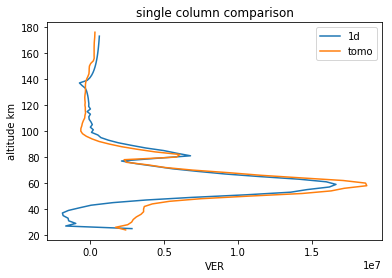

In [12]:
fig,ax = plt.subplots()
ax.plot(result_1d.isel(date=int(round(len(im_lst)/2)-1)), z*1e-3, label='1d')
ax.plot(result_tomo.isel(alpha=int(round(len(grid_alpha)/2)-1), 
                         beta=int(round(len(grid_beta)/2)-1)), grid_rho*1e-3, label='tomo')
ax.set(xlabel='VER',
      ylabel='altitude km',
      title='single column comparison')
plt.legend()
plt.show()

## measurement response

In [13]:
A = G.dot(K_coo)
mr_tomo = np.zeros(shape_tomo)
for alpha_id in range(len(grid_alpha)):
    for beta_id in range(len(grid_beta)):
        for rho_id in range(len(grid_rho)):
            grid_id = np.ravel_multi_index((alpha_id, beta_id, rho_id), shape_tomo)
            mr_tomo[alpha_id, beta_id, rho_id] = A[grid_id,:].toarray().squeeze().reshape(shape_tomo).sum()
mr_tomo = xr.DataArray(mr_tomo, coords=result_tomo.coords, dims=result_tomo.dims)

#plt.plot(mr_tomo[1, :, :].T, grid_rho*1e-3)
#plt.xlabel('sum of A rows (measurement response)')
#plt.ylabel('z km')
#plt.title('measurement response (find a better way to plot!)')
#plt.show()

### check averaging kernel (tomo) of 1 grid point (in the middle)

mreasurement response of grid 1803: 1.3993220022909731


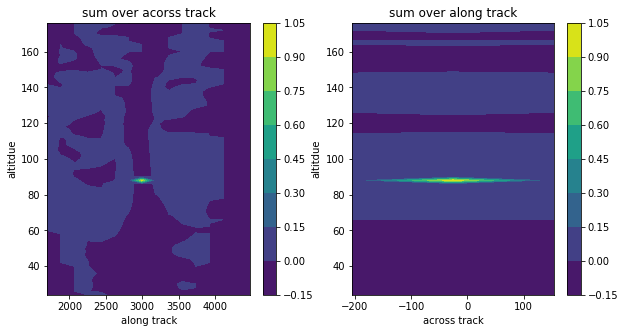

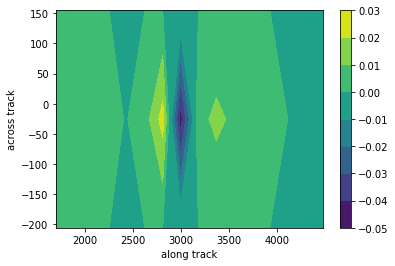

In [14]:
A = G.dot(K_coo)
alpha_id = 1
beta_id = round((len(grid_beta))/2)-1
#shape_tomo = (len(edges_alpha)+1, len(edges_beta)+1, len(edges_rho)+1)
grid_id = np.ravel_multi_index((alpha_id, beta_id, 32), shape_tomo)
A_row = A[grid_id,:]
AAA = A_row.toarray().squeeze().reshape(shape_tomo)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.contourf(grid_beta*Re, grid_rho*1e-3, AAA.sum(axis=0).T)
plt.title('sum over acorss track')
plt.xlabel('along track')
plt.ylabel('altitdue')
plt.colorbar()

plt.subplot(122)
plt.contourf(grid_alpha*Re, grid_rho*1e-3, AAA.sum(axis=1).T)
plt.title('sum over along track')
plt.xlabel('across track')
plt.ylabel('altitdue')
plt.colorbar()


plt.figure()
plt.contourf(grid_beta*Re, grid_alpha*Re, AAA[:, :, 30])
plt.xlabel('along track')
plt.ylabel('across track')
plt.colorbar()

print('mreasurement response of grid {}:'.format(grid_id), AAA.sum()) #measurement response


## select tomo result that measurement response is large enough

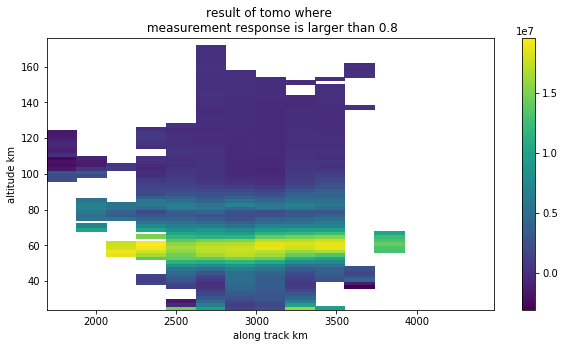

In [15]:
plt.figure(figsize=(10,5))
plt.pcolor(grid_beta*Re, grid_rho*1e-3, result_tomo.where(mr_tomo>mr_threshold).isel(alpha=1).T)
plt.xlabel('along track km')
plt.ylabel('altitude km')
plt.title('result of tomo where \n measurement response is larger than {}'.format(mr_threshold))
plt.colorbar()

## compare averaged profiles between tomo and 1d

/Users/anqili/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


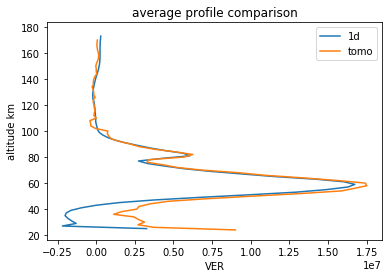

In [16]:
result_tomo_mean = result_tomo.where(mr_tomo>mr_threshold).mean(dim='beta',skipna=True).mean(dim='alpha',skipna=True)

fig, ax = plt.subplots()
ax.plot(result_1d_mean, z*1e-3, label='1d')
ax.plot(result_tomo_mean, grid_rho*1e-3, label='tomo')
ax.set(xlabel='VER',
      ylabel='altitude km',
      title='average profile comparison')
ax.legend()
plt.show()

## something else

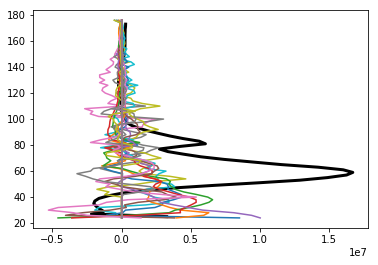

In [17]:
abc = (x_hat-xa).reshape(shape_tomo)
plt.figure()
fig, ax = plt.subplots()
ax.set_xscale('linear')
ax.plot(result_1d_mean, z*1e-3, 'k-', linewidth=3)
for i in range(len(grid_alpha)):
    for j in range(len(grid_beta)):
        ax.plot(abc[i,j,:], grid_rho*1e-3, '-')


# Ozone calculation (on 1d retrieved ver)

In [18]:
def ozone_onion_peel(O2sd_ver, z, zenithangle):
    from chemi import ozone_sme, oxygen_atom, gfactor
    from geometry_functions import pathleng
    from scipy.io import loadmat
    import sys
    sys.path.append('..')
    MSIS = loadmat('../msisdata.mat')
    zMsis = MSIS['zMsis'].squeeze() # in km
    TMsis = MSIS['TMsis'] # in K
    NMsis = MSIS['NMsis'] # in cm-3 
    monthMsis = MSIS['monthMsis'].squeeze()
    latMsis = MSIS['latMsis'].squeeze()
    month = 6 #temp
    lat = 1 #temp
    T = interp1d(zMsis*1e3, TMsis[:,month,lat], fill_value='extrapolate')(z)
    M = interp1d(zMsis*1e3, NMsis[:,month,lat], fill_value='extrapolate')(z)

    #calculate O2 photosythesis rate 
    zenithangle = 30 #temp
    gA = gfactor(0.2*M, T, z, zenithangle)

    #==== ozone onion peel   
    sigma = loadmat('sigma.mat')
    sO = sigma['sO'].squeeze() #sigma [cm2]
    sO2 = sigma['sO2'].squeeze() #sigma [cm2]
    sO3 = sigma['sO3'].squeeze() #sigma [cm2]
    sN2 = sigma['sN2'].squeeze() #sigma [cm2]
    irrad = sigma['irrad'].squeeze() #irradiance [cm-2 s-1]
    wave = sigma['wave'].squeeze() #wavelength grid [nm]
    hartrange = (wave > 210) & (wave < 310)
    srcrange = (wave > 122) & (wave < 175)
    lyarange = 28  # wavelength = 121.567 nm

    O2 = 0.21 * M # molec cm-3 
    N2 = 0.78 * M # molec cm-3
    pathl = pathleng(z, zenithangle) * 1e2  # [m -> cm]
    
    O3 = np.zeros(z.shape)
    Jhart = np.zeros(z.shape)
    jhart_max = 8e-3

    # top layer with Jhart max
    Jhart[-1] = jhart_max
    O3[-1] = ozone_sme(M[-1], T[-1], O2sd_ver[-1], 
                      jhart=Jhart[-1], js=gA[-1])

    # from the second top layers ......
    for i in range(len(z)-2, -1, -1):
        #tau_o = sO * O.dot(pathl[i+1,:])
        tau_o2 = sO2 * O2.dot(pathl[i+1,:])
        tau_n2 = sN2 * N2.dot(pathl[i+1,:])
        tau_o3 = sO3 * O3.dot(pathl[i+1,:])
        tau = tau_o2 + tau_n2 + tau_o3
        tau = tau_o3

        jO3 = irrad * sO3 * np.exp(-tau)

        jhart = jO3[hartrange].sum()
        Jhart[i] = jhart
        O3[i] = ozone_sme(M[i], T[i], O2sd_ver[i], jhart=Jhart[i], js=gA[i])

        if jhart < 1e-4:
            break
    return O3 

In [19]:
O2sd_ver = result_1d.isel(date=int(round(len(im_lst)/2)-1)) #choose a VER profile in the middle of the track
O2sd_ver = np.abs(O2sd_ver) #temp
O2sd_ver = O2sd_ver.fillna(0) #temp
O3_1d = ozone_onion_peel(O2sd_ver, z, zenithangle=0)

O2sd_ver = result_tomo.isel(alpha=int(round(len(grid_alpha)/2)-1), 
                            beta=int(round(len(grid_beta)/2)-1)) #choose a VER profile in the middle of the track
O2sd_ver = np.abs(O2sd_ver) #temp
O2sd_ver = O2sd_ver.fillna(0) #temp
O3_tomo = ozone_onion_peel(O2sd_ver, grid_rho, zenithangle=0)

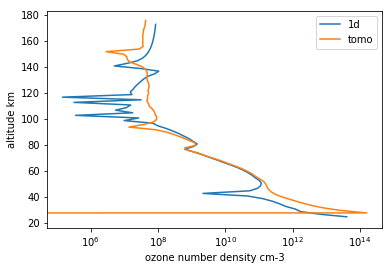

In [20]:
fig, ax = plt.subplots()
ax.plot(O3_1d, z*1e-3, '-', label='1d')
ax.plot(O3_tomo, grid_rho*1e-3, '-',label='tomo')
ax.set_xscale('log')
ax.set(xlabel='ozone number density cm-3',
      ylabel='altitude km')
#ax.set(ylim=(40, 120))
plt.legend()
plt.show()